<a href="https://colab.research.google.com/github/babaroscopy/colab/blob/main/Alexnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Rohit-Kundu/Ensemble-Pneumonia-Detection.git

Cloning into 'Ensemble-Pneumonia-Detection'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 85 (delta 50), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (85/85), done.


In [2]:
!pip install -r Ensemble-Pneumonia-Detection/requirements.txt

ERROR: Could not find a version that satisfies the requirement torch==1.9.0+cu102 (from versions: 0.4.1, 0.4.1.post2, 1.0.0, 1.0.1, 1.0.1.post2, 1.1.0, 1.2.0, 1.3.0, 1.3.1, 1.4.0, 1.5.0, 1.5.1, 1.6.0, 1.7.0, 1.7.1, 1.8.0, 1.8.1, 1.9.0, 1.9.1, 1.10.0)
ERROR: No matching distribution found for torch==1.9.0+cu102


In [3]:
from google.colab import files

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [6]:
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [7]:
ls

chest-xray-pneumonia.zip  flickr8k.zip  kaggle.json


In [9]:
# Location of Zip File
drive_path = '/content/gdrive/My Drive/Kaggle/chest-xray-pneumonia.zip'
local_path = '/content'

# Copy the zip file and move it up one level (AKA out of the drive folder)
!cp '{drive_path}' .

# Navigate to the copied file and unzip it quietly
os.chdir(local_path)
!unzip -q 'chest-xray-pneumonia.zip'

In [10]:
!cp -r chest_xray/chest_xray/ Ensemble-Pneumonia-Detection/data/

In [11]:
!cp -r Ensemble-Pneumonia-Detection/data/test/NORMAL/*.jpeg Ensemble-Pneumonia-Detection/data/val/NORMAL/
!cp -r Ensemble-Pneumonia-Detection/data/test/PNEUMONIA/*.jpeg Ensemble-Pneumonia-Detection/data/val/PNEUMONIA/

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import csv
import numpy as np
import pandas as pd
from sklearn.metrics import *
import math
#import scikitplot as skplt 

In [13]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

data_dir = "Ensemble-Pneumonia-Detection/data"

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=2) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
num_classes = len(class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names)

['NORMAL', 'PNEUMONIA']


In [14]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

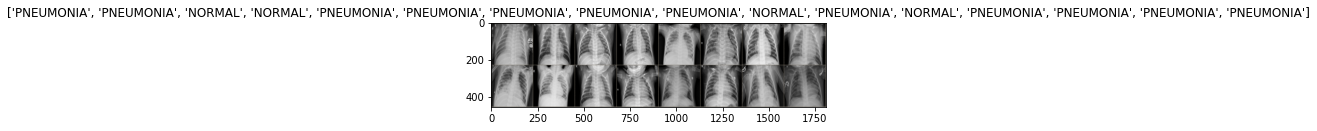

In [15]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [16]:
def plot(val_loss,train_loss,typ):
    plt.title("{} after epoch: {}".format(typ,len(train_loss)))
    plt.xlabel("Epoch")
    plt.ylabel(typ)
    plt.plot(list(range(len(train_loss))),train_loss,color="r",label="Train "+typ)
    plt.plot(list(range(len(val_loss))),val_loss,color="b",label="Validation "+typ)
    plt.legend()
    plt.show()
    plt.savefig(os.path.join(data_dir,typ+".png"))
    plt.close()

In [17]:
val_loss_gph=[]
train_loss_gph=[]
val_acc_gph=[]
train_acc_gph=[]

def train_model(model, criterion, optimizer, scheduler, num_epochs=25,model_name = "kaggle"):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) #was (outputs,1) for non-inception and (outputs.data,1) for inception
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
              train_loss_gph.append(epoch_loss)
              train_acc_gph.append(epoch_acc)
            if phase == 'val':
              val_loss_gph.append(epoch_loss)
              val_acc_gph.append(epoch_acc)
            
           # plot(val_loss_gph,train_loss_gph, "Loss")
           # plot(val_acc_gph,train_acc_gph, "Accuracy")

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc >= best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model, data_dir+"/"+model_name+".h5")
                print('==>Model Saved')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    plot(val_loss_gph,train_loss_gph, "Loss")
    plot(val_acc_gph,train_acc_gph, "Accuracy")
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

**Alexnet**

In [19]:
model = models.alexnet(pretrained = True)

#num_ftrs = model.fc.in_features  ##for googlenet, resnet18
num_ftrs = model.classifier[6].in_features  ## for densenet169
print("Number of features: "+str(num_ftrs))

Number of features: 4096


In [20]:
#model.fc = nn.Linear(num_ftrs, num_classes)  ##for googlenet, resnet18
model.classifier[6] = nn.Linear(num_ftrs, num_classes) ## for densenet169
model = model.to(device)

In [21]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [22]:
# StepLR Decays the learning rate of each parameter group by gamma every step_size epochs
# Decay LR by a factor of 0.1 every 7 epochs
# Learning rate scheduling should be applied after optimizer’s update
# e.g., you should write your code this way:
# for epoch in range(100):
#     train(...)
#     validate(...)
#     scheduler.step()
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 10, gamma=0.1)

Epoch 1/15
----------
train Loss: 0.1136 Acc: 0.9534
val Loss: 1.4636 Acc: 0.7797
==>Model Saved

Epoch 2/15
----------
train Loss: 0.0599 Acc: 0.9774
val Loss: 1.7457 Acc: 0.7109

Epoch 3/15
----------
train Loss: 0.0378 Acc: 0.9850
val Loss: 1.0497 Acc: 0.8250
==>Model Saved

Epoch 4/15
----------
train Loss: 0.0340 Acc: 0.9891
val Loss: 2.1433 Acc: 0.8234

Epoch 5/15
----------
train Loss: 0.0325 Acc: 0.9914
val Loss: 2.4608 Acc: 0.7328

Epoch 6/15
----------
train Loss: 0.0197 Acc: 0.9921
val Loss: 3.1454 Acc: 0.7781

Epoch 7/15
----------
train Loss: 0.0343 Acc: 0.9883
val Loss: 2.0424 Acc: 0.7578

Epoch 8/15
----------
train Loss: 0.0194 Acc: 0.9935
val Loss: 1.6217 Acc: 0.8094

Epoch 9/15
----------
train Loss: 0.0135 Acc: 0.9958
val Loss: 2.0235 Acc: 0.7594

Epoch 10/15
----------
train Loss: 0.0099 Acc: 0.9969
val Loss: 4.7498 Acc: 0.7422

Epoch 11/15
----------
train Loss: 0.0012 Acc: 0.9996
val Loss: 3.9086 Acc: 0.7719

Epoch 12/15
----------
train Loss: 0.0026 Acc: 0.9992
v

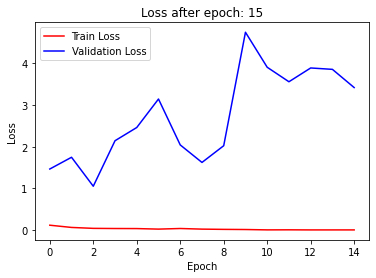

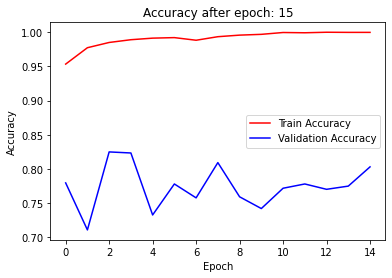

In [23]:
model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=15, model_name = "alexnet")

In [24]:
!mkdir Ensemble-Pneumonia-Detection/train_csv
!mkdir Ensemble-Pneumonia-Detection/test_csv
#f = open("Ensemble-Pneumonia-Detection/train_csv/resnet18_train.csv", "x")
#f = open("Ensemble-Pneumonia-Detection/test_csv/resnet18_test.csv", "x")
#f = open("Ensemble-Pneumonia-Detection/train_csv/googlenet_train.csv", "x")
#f = open("Ensemble-Pneumonia-Detection/test_csv/googlenet_test.csv", "x")
#f = open("Ensemble-Pneumonia-Detection/train_csv/densenet121_train.csv", "x")
#f = open("Ensemble-Pneumonia-Detection/test_csv/densenet121_test.csv", "x")
f = open("Ensemble-Pneumonia-Detection/train_csv/alexnet_train.csv", "x")
f = open("Ensemble-Pneumonia-Detection/test_csv/alexnet_test.csv", "x")
f = open("Ensemble-Pneumonia-Detection/train_labels.csv", "x")
f = open("Ensemble-Pneumonia-Detection/test_labels.csv", "x")

In [25]:
# Getting Proba distribution
print("\nGetting the Probability Distribution")
trainloader=torch.utils.data.DataLoader(image_datasets['train'],batch_size=1)
testloader=torch.utils.data.DataLoader(image_datasets['val'],batch_size=1)


Getting the Probability Distribution


In [26]:
model=model.eval()

In [31]:
correct = 0
total = 0
data_dir = "Ensemble-Pneumonia-Detection/train_csv"
#Train Probabilities
f = open(data_dir+"/alexnet_train.csv",'w+',newline = '')
writer = csv.writer(f)
saving = []
with torch.no_grad():
      num = 0
      temp_array = np.zeros((len(trainloader),num_classes))
      for i,data in enumerate(trainloader):
          images, labels = data
          sample_fname, _ = trainloader.dataset.samples[i]
          labels=labels.cuda()
          outputs = model(images.cuda())
          _, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels.cuda()).sum().item()
          prob = torch.nn.functional.softmax(outputs, dim=1)
          saving.append(sample_fname.split('/')[-1])
          temp_array[num] = np.asarray(prob[0].tolist()[0:num_classes])
          num+=1
print("Train Accuracy = ",100*correct/total)
for i in range(len(trainloader)):
  k = temp_array[i].tolist()
  k.append(saving[i])
  writer.writerow(k)

f.close()

Train Accuracy =  99.42484662576688


In [32]:
data_dir = "Ensemble-Pneumonia-Detection"

f = open(data_dir+"/train_labels.csv",'w+',newline = '')
writer = csv.writer(f)
for i,data in enumerate(testloader):
  _, labels = data
  sample_fname, _ = testloader.dataset.samples[i]
  sample = sample_fname.split('/')[-1]
  lab = labels.tolist()[0]
  writer.writerow([sample,lab])
f.close()

In [33]:
data_dir = "Ensemble-Pneumonia-Detection/test_csv"

#Test Probabilities
f = open(data_dir+"/alexnet_test.csv",'w+',newline = '')
writer = csv.writer(f)
saving = []
with torch.no_grad():
      num = 0
      temp_array = np.zeros((len(testloader),num_classes))
      for i,data in enumerate(testloader):
          images, labels = data
          sample_fname, _ = testloader.dataset.samples[i]
          labels=labels.cuda()
          outputs = model(images.cuda())
          _, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels.cuda()).sum().item()
          prob = torch.nn.functional.softmax(outputs, dim=1)
          saving.append(sample_fname.split('/')[-1])
          temp_array[num] = np.asarray(prob[0].tolist()[0:num_classes])
          num+=1
print("Test Accuracy = ",100*correct/total)
for i in range(len(testloader)):
  k = temp_array[i].tolist()
  k.append(saving[i])
  writer.writerow(k)

f.close()

Test Accuracy =  97.57513661202186


In [34]:
data_dir = "Ensemble-Pneumonia-Detection"

f = open(data_dir+"/test_labels.csv",'w+',newline = '')
writer = csv.writer(f)
for i,data in enumerate(testloader):
  _, labels = data
  sample_fname, _ = testloader.dataset.samples[i]
  sample = sample_fname.split('/')[-1]
  lab = labels.tolist()[0]
  writer.writerow([sample,lab])
f.close()